In [36]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
import networkx as nx 


import warnings

# supressing the warning on the usage of Linear Regression model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [2]:
#read in data
df = pd.read_csv("tnt_fires.csv")
df.head(10)

Unnamed: 0   latitude  longitude  bright_ti4  scan  track    acq_date  \
0           0  10.312501 -61.445774      337.17  0.42   0.38  2012-01-20   
1           1  10.314243 -61.444729      311.88  0.60   0.53  2012-01-21   
2           2  10.312764 -61.446404      311.47  0.40   0.37  2012-01-23   
3           3  10.316153 -61.445877      306.26  0.40   0.37  2012-01-23   
4           4  10.315652 -61.444736      301.35  0.79   0.78  2012-01-25   
5           5  10.312988 -61.443657      307.08  0.79   0.78  2012-01-25   
6           6  10.353363 -61.459435      303.14  0.38   0.59  2012-01-26   
7           7  10.309649 -61.445797      313.91  0.38   0.59  2012-01-26   
8           8  10.315046 -61.444763      308.50  0.38   0.59  2012-01-26   
9           9  10.384198 -61.474968      303.53  0.38   0.59  2012-01-26   

   acq_time satellite instrument confidence  version  bright_ti5   frp  \
0      1732         N      VIIRS          n        1      302.22  3.43   
1       607         N      VIIRS          n        1      291.45  3.02   
2       530         N      VIIRS          n        1      289.84  1.09   
3       530         N      VIIRS          n        1      290.75  1.09   
4       632         N      VIIRS          n        1      284.33  3.37   
5       632         N      VIIRS          n        1      285.38  2.78   
6       614         N      VIIRS          n        1      290.27  0.40   
7       614         N      VIIRS          n        1      289.34  0.91   
8       614         N      VIIRS          n        1      290.72  0.91   
9       614         N      VIIRS          n        1      290.36  0.75   

  daynight  type  
0        D     2  
1        N     2  
2        N     2  
3        N     2  
4        N     2  
5        N     2  
6        N     0  
7        N     2  
8        N     2  
9        N     2

In [3]:
#1 reflect day and 2 reflects night
df.daynight.replace(('D','N'),(1,2), inplace=True)

#drop unecessary columns
df = df.drop(labels=["Unnamed: 0","version","acq_date","acq_time", "satellite"],axis="columns") 

In [4]:
df

latitude  longitude  bright_ti4  scan  track instrument confidence  \
0      10.312501 -61.445774      337.17  0.42   0.38      VIIRS          n   
1      10.314243 -61.444729      311.88  0.60   0.53      VIIRS          n   
2      10.312764 -61.446404      311.47  0.40   0.37      VIIRS          n   
3      10.316153 -61.445877      306.26  0.40   0.37      VIIRS          n   
4      10.315652 -61.444736      301.35  0.79   0.78      VIIRS          n   
...          ...        ...         ...   ...    ...        ...        ...   
13057  10.408938 -61.478539      305.12  0.41   0.37      VIIRS          n   
13058  10.398152 -61.476540      305.25  0.41   0.37      VIIRS          n   
13059  10.406925 -61.479237      305.18  0.46   0.39      VIIRS          n   
13060  10.416850 -61.479599      306.00  0.61   0.53      VIIRS          n   
13061  10.526433 -61.433891      340.84  0.42   0.38      VIIRS          n   

       bright_ti5   frp daynight  type  
0          302.22  3.43        1     2  
1          291.45  3.02        2     2  
2          289.84  1.09        2     2  
3          290.75  1.09        2     2  
4          284.33  3.37        2     2  
...           ...   ...      ...   ...  
13057      292.38  1.30        2     2  
13058      292.20  0.92        2     0  
13059      291.97  0.63        2     2  
13060      292.40  1.23        2     2  
13061      300.80  3.29        1     0  

[13062 rows x 11 columns]

In [5]:
df.describe()

latitude     longitude    bright_ti4          scan         track  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean      10.365658    -61.414573    324.121742      0.458496      0.470715   
std        0.165040      0.137678     16.201939      0.085135      0.110984   
min       10.043399    -61.925179    295.050000      0.320000      0.360000   
25%       10.306740    -61.476427    307.302500      0.390000      0.380000   
50%       10.341971    -61.445057    329.230000      0.430000      0.430000   
75%       10.419772    -61.386962    336.550000      0.510000      0.550000   
max       11.281098    -60.533905    367.000000      0.800000      0.780000   

         bright_ti5           frp          type  
count  13062.000000  13062.000000  13062.000000  
mean     294.026132      3.777610      0.959348  
std        6.520188      4.136054      1.084424  
min      250.940000      0.080000      0.000000  
25%      290.670000      1.410000      0.000000  
50%      293.470000      2.620000      0.000000  
75%      298.800000      4.740000      2.000000  
max      316.120000    114.620000      3.000000

In [6]:
#drop instrument column as it is the same value for all entries
df = df.drop(labels=["instrument"],axis="columns") 

#replace low, nominal and high confidence with 1, 2 and 3 respectively
df.confidence.replace(('l','n','h'),(1,2,3), inplace=True)

In [7]:
#rename confidence column label
df = df.rename(columns={'confidence': 'label'})
df

latitude  longitude  bright_ti4  scan  track  label  bright_ti5   frp  \
0      10.312501 -61.445774      337.17  0.42   0.38      2      302.22  3.43   
1      10.314243 -61.444729      311.88  0.60   0.53      2      291.45  3.02   
2      10.312764 -61.446404      311.47  0.40   0.37      2      289.84  1.09   
3      10.316153 -61.445877      306.26  0.40   0.37      2      290.75  1.09   
4      10.315652 -61.444736      301.35  0.79   0.78      2      284.33  3.37   
...          ...        ...         ...   ...    ...    ...         ...   ...   
13057  10.408938 -61.478539      305.12  0.41   0.37      2      292.38  1.30   
13058  10.398152 -61.476540      305.25  0.41   0.37      2      292.20  0.92   
13059  10.406925 -61.479237      305.18  0.46   0.39      2      291.97  0.63   
13060  10.416850 -61.479599      306.00  0.61   0.53      2      292.40  1.23   
13061  10.526433 -61.433891      340.84  0.42   0.38      2      300.80  3.29   

      daynight  type  
0            1     2  
1            2     2  
2            2     2  
3            2     2  
4            2     2  
...        ...   ...  
13057        2     2  
13058        2     0  
13059        2     2  
13060        2     2  
13061        1     0  

[13062 rows x 10 columns]

In [8]:
df.corr()

latitude  longitude  bright_ti4      scan     track     label  \
latitude    1.000000   0.462484    0.058291  0.001607  0.007905  0.010453   
longitude   0.462484   1.000000    0.173245 -0.040995 -0.017117  0.000336   
bright_ti4  0.058291   0.173245    1.000000 -0.212235 -0.171532  0.009883   
scan        0.001607  -0.040995   -0.212235  1.000000  0.471319  0.041463   
track       0.007905  -0.017117   -0.171532  0.471319  1.000000  0.151742   
label       0.010453   0.000336    0.009883  0.041463  0.151742  1.000000   
bright_ti5  0.035370   0.106974    0.650666 -0.237644 -0.393813 -0.197064   
frp         0.036372   0.109179    0.608416  0.032315 -0.042071  0.013784   
type       -0.085777  -0.267606   -0.628536  0.158905  0.123980  0.080737   

            bright_ti5       frp      type  
latitude      0.035370  0.036372 -0.085777  
longitude     0.106974  0.109179 -0.267606  
bright_ti4    0.650666  0.608416 -0.628536  
scan         -0.237644  0.032315  0.158905  
track        -0.393813 -0.042071  0.123980  
label        -0.197064  0.013784  0.080737  
bright_ti5    1.000000  0.394972 -0.468898  
frp           0.394972  1.000000 -0.354272  
type         -0.468898 -0.354272  1.000000

In [9]:
df.head(1)

latitude  longitude  bright_ti4  scan  track  label  bright_ti5   frp  \
0  10.312501 -61.445774      337.17  0.42   0.38      2      302.22  3.43   

  daynight  type  
0        1     2

In [47]:
# Get feature labels
features = ["latitude", "longitude","bright_ti4", "scan", "track","label","bright_ti5", "daynight", "frp"]

# Separating out the target
X = df.loc[:, features].values 
y = df.loc[:,["type"]].values.ravel() 

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state = 100) # 70% training and 30% test


# Oversample the data to correct the imbalance in fires
count = Counter( y)
print("Before oversampling: {}".format(count))

sm = SMOTE(random_state = 100)

X_sm, y_sm = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state = 100) # 70% training and 30% test


count = Counter( y_sm)
print("After oversampling: {}".format(count))

Before oversampling: Counter({0: 7183, 2: 5106, 3: 773})
After oversampling: Counter({2: 7183, 0: 7183, 3: 7183})


In [11]:
# Logistic Regression Classification
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

scaler.fit(df.drop('type',axis=1))

scaled_features = scaler.transform(df.drop('label',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()


logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train,y_train)

predictions = logmodel.predict(X_test)

from sklearn import metrics
logmodel.score(X_train,y_train)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))



from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

E:\Anaconda\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- type
Feature names seen at fit time, yet now missing:
- label

  warnings.warn(message, FutureWarning)


Accuracy: 0.6108275328692963
[[1830  226   95]
 [ 210 1774  193]
 [ 618 1174  345]]
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      2151
           2       0.56      0.81      0.66      2177
           3       0.55      0.16      0.25      2137

    accuracy                           0.61      6465
   macro avg       0.60      0.61      0.56      6465
weighted avg       0.60      0.61      0.56      6465



In [12]:
# Check accuracy
accuracy1 = round(logmodel.score(X_train, y_train) * 100,2) #99.33
print("Model train accuracy:", accuracy1)


accuracy2 = round(logmodel.score(X_test, y_test) * 100,2) 
print("Model test accuracy:", accuracy2)

#print ('Model Recall: {}'.format(recall_score(y_test,y_pred)))
#print ('Model F1 Score: {}'.format(f1_score(y_test,y_pred)))
#print ('Model ROC: {}'.format(roc_auc_score(y_test,y_pred)))
#print ('Model Confusion Matrix:\n {}'.format(confusion_matrix(y_test,y_pred)))
#print ('Model Classification Report:\n {}'.format(classification_report(y_test,y_pred)))

Model train accuracy: 60.81
Model test accuracy: 61.08


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df.drop('type',axis=1))
scaled_features = scaler.transform(df.drop('type',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

latitude  longitude  bright_ti4      scan     track     label  bright_ti5  \
0 -0.322101  -0.226630    0.805382 -0.452197 -0.817399  0.144702    1.256740   
1 -0.311546  -0.219040   -0.755602  1.662167  0.534195  0.144702   -0.395116   
2 -0.320507  -0.231206   -0.780908 -0.687126 -0.907506  0.144702   -0.642051   
3 -0.299972  -0.227378   -1.102487 -0.687126 -0.907506  0.144702   -0.502479   
4 -0.303008  -0.219090   -1.405549  3.893996  2.786851  0.144702   -1.487151   

        frp  daynight  
0 -0.084047 -0.866038  
1 -0.183179  1.043192  
2 -0.649825  1.043192  
3 -0.649825  1.043192  
4 -0.098554  1.043192

In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

Maximum accuracy:- 0.8190865016585863 at K = 10


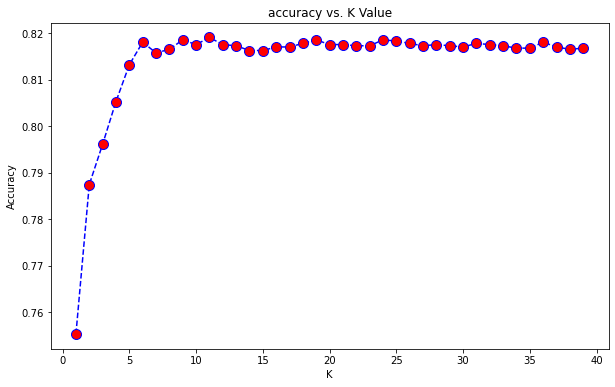

In [55]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(Xtrain,ytrain)
    yhat = neigh.predict(Xtest)
    acc.append(metrics.accuracy_score(ytest, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

Text(0, 0.5, 'Error Rate')

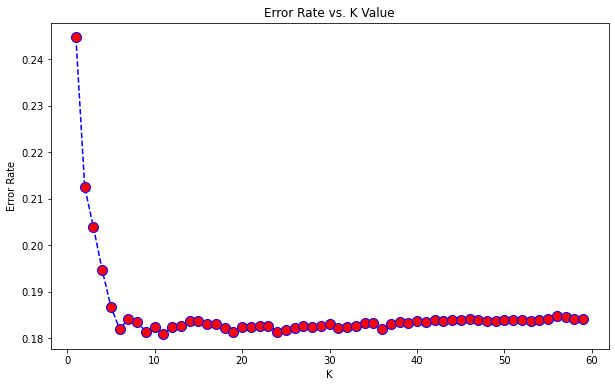

In [56]:
error_rate = []

for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(Xtrain,ytrain)
    pred_i = knn.predict(Xtest)
    error_rate.append(np.mean(pred_i != ytest))


plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [57]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('WITH K=10')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=10


[[1606  240  305]
 [ 220 1444  513]
 [ 161  209 1767]]


              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2151
           2       0.76      0.66      0.71      2177
           3       0.68      0.83      0.75      2137

    accuracy                           0.75      6465
   macro avg       0.75      0.75      0.74      6465
weighted avg       0.75      0.75      0.74      6465



In [64]:
knn.score(X_test, y_test)

0.7392111368909513

In [65]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.7392111368909513


In [66]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('WITH K=11')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=11


[[1570  246  335]
 [ 205 1416  556]
 [ 161  183 1793]]


              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2151
           2       0.77      0.65      0.70      2177
           3       0.67      0.84      0.74      2137

    accuracy                           0.74      6465
   macro avg       0.75      0.74      0.74      6465
weighted avg       0.75      0.74      0.74      6465



In [67]:
knn.score(X_test, y_test)

0.7392111368909513

In [68]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.7392111368909513


In [69]:
# Support Vector Machine
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [75]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test, y_pred))

[[1570  246  335]
 [ 205 1416  556]
 [ 161  183 1793]]


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2151
           2       0.90      0.88      0.89      2177
           3       0.83      0.86      0.84      2137

    accuracy                           0.88      6465
   macro avg       0.88      0.88      0.88      6465
weighted avg       0.88      0.88      0.88      6465



In [76]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8841453982985306


In [72]:
df.head(1)

latitude  longitude  bright_ti4  scan  track  label  bright_ti5   frp  \
0  10.312501 -61.445774      337.17  0.42   0.38      2      302.22  3.43   

  daynight  type  
0        1     2

In [126]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


feature_cols = ['latitude', 'longitude', 'bright_ti4', 'scan','track','bright_ti5','frp','daynight','label']
X = df[feature_cols]
y = df['type']

sm = SMOTE(random_state = 100)

X_sm, y_sm = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state = 100) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=None)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8875483372003093


In [78]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test, y_pred))

[[1570  246  335]
 [ 205 1416  556]
 [ 161  183 1793]]


              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2151
           2       0.90      0.88      0.89      2177
           3       0.83      0.85      0.84      2137

    accuracy                           0.88      6465
   macro avg       0.89      0.88      0.89      6465
weighted avg       0.89      0.88      0.89      6465



In [74]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [72]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [73]:
df.head(1)

Unnamed: 0   latitude  longitude  bright_ti4  scan  track  label  \
0           0  10.312501 -61.445774      337.17  0.42   0.38      2   

   bright_ti5   frp daynight  type  
0      302.22  3.43        1     2

In [74]:
conda install graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [76]:
conda install -c conda-forge pydotplus

Solving environment: ...working... done

## Package Plan ##

  environment location: E:\Anaconda

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       h5b45459_0         176 KB  conda-forge
    certifi-2021.10.8          |   py39hcbf5309_2         145 KB  conda-forge
    conda-4.12.0               |   py39hcbf5309_0         1.0 MB  conda-forge
    openssl-1.1.1n             |       h8ffe710_0         5.7 MB  conda-forge
    pydotplus-2.0.2            |             py_2          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.1 MB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-py_2

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certif

In [127]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1','2','3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('firetree.png')
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.460127 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.460127 to fit



In [76]:
df.head(1)

latitude  longitude  bright_ti4  scan  track  label  bright_ti5   frp  \
0  10.312501 -61.445774      337.17  0.42   0.38      2      302.22  3.43   

  daynight  type  
0        1     2

In [27]:
prior = df.groupby('type').size().div(len(df)) #count()['Age']/len(data)
print(prior)

type
0    0.549916
2    0.390905
3    0.059179
dtype: float64


In [28]:
#liklihood of type given feature
likelihood = {}
likelihood['bright_ti4'] = df.groupby(['type', 'bright_ti4']).size().div(len(df)).div(prior)
likelihood['label'] = df.groupby(['type', 'label']).size().div(len(df)).div(prior)
likelihood['bright_ti5'] = df.groupby(['type', 'bright_ti5']).size().div(len(df)).div(prior)
likelihood['frp'] = df.groupby(['type', 'frp']).size().div(len(df)).div(prior)
likelihood['daynight'] = df.groupby(['type', 'daynight']).size().div(len(df)).div(prior)

print (likelihood)

{'bright_ti4': type  bright_ti4
0     295.35        0.000139
      295.73        0.000139
      295.76        0.000139
      295.81        0.000139
      295.92        0.000139
                      ...   
3     355.94        0.001294
      355.99        0.001294
      356.12        0.001294
      356.51        0.001294
      367.00        0.001294
Length: 6081, dtype: float64, 'label': type  label
0     1        0.067103
      2        0.916748
      3        0.016149
2     1        0.009597
      2        0.988053
      3        0.002350
3     1        0.034929
      2        0.963777
      3        0.001294
dtype: float64, 'bright_ti5': type  bright_ti5
0     258.23        0.000139
      265.16        0.000139
      267.35        0.000139
      267.79        0.000139
      268.67        0.000139
                      ...   
3     305.52        0.001294
      305.65        0.001294
      305.71        0.001294
      308.75        0.001294
      311.46        0.001294
Length: 4499, dt

In [30]:
df['bright_ti4'].value_counts(normalize=True).sort_index()

295.05    0.000153
295.07    0.000077
295.19    0.000077
295.21    0.000077
295.23    0.000077
            ...   
356.71    0.000077
356.73    0.000077
356.80    0.000077
356.89    0.000153
367.00    0.010335
Name: bright_ti4, Length: 4400, dtype: float64

In [91]:
# This function helps to calculate probability distribution, which goes into BBN 
def probs(data, child, parent1=None, parent2=None, parent3=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent, 2 parents or 3 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            if parent3==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent2],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2],data[parent3]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [119]:
# Setting up nodes
# Separate columns based on normalized frequencies of the variable categories from the data.
# Separator of 324.12 used(average of bright_ti4 column)
#E.g., the “bright_ti4” variable has 5865 observations where the value is ≤324.12 and 7198 where the value is >324.12.
# Create nodes by manually typing in probabilities
bright4 = BbnNode(Variable(0, 'bright4', ['<=300','300-330', '>330']), probs(df, child='bright_ti4'))
bright5 = BbnNode(Variable(1, 'bright5', ['<=270','270-300', '>300']), probs(df, child='bright_ti5'))
conf = BbnNode(Variable(2, 'conf', ['l', 'n', 'h']), probs(df, child='label'))
FF = BbnNode(Variable(3, 'FF', ['0', '2','3']), probs(df, child='type', parent1='bright_ti4', parent2='bright_ti5', parent3="label"))

# Create Network
bbn = Bbn() \
    .add_node(bright4) \
    .add_node(bright5) \
    .add_node(conf) \
    .add_edge(Edge(bright4, FF, EdgeType.DIRECTED)) \
    .add_edge(Edge(bright5, FF, EdgeType.DIRECTED)) \
    .add_edge(Edge(conf, FF, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

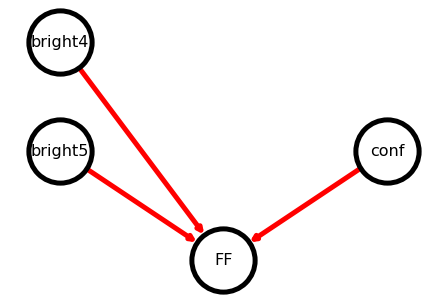

In [120]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [121]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 1|bright5|<=270,270-300,>300
Values:
1=<=270|0.33333
1=270-300|0.33333
1=>300|0.33333
----------------
Node: 2|conf|l,n,h
Values:
2=l|0.04272
2=n|0.94740
2=h|0.00988
----------------
Node: 3|FF|0,2,3
Values:
3=0|0.08854
3=2|0.75109
3=3|0.16037
----------------
Node: 0|bright4|<=300,300-330,>330
Values:
0=<=300|0.50000
0=300-330|0.25000
0=>330|0.25000
----------------


In [123]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
evidence('ev1', 'conf', 'l', 1.0)


# Print marginal probabilities
print_probs()

Node: 1|bright5|<=270,270-300,>300
Values:
1=<=270|0.33333
1=270-300|0.33333
1=>300|0.33333
----------------
Node: 2|conf|l,n,h
Values:
2=l|1.00000
2=n|0.00000
2=h|0.00000
----------------
Node: 3|FF|0,2,3
Values:
3=0|0.16667
3=2|0.83333
3=3|0.00000
----------------
Node: 0|bright4|<=300,300-330,>330
Values:
0=<=300|0.50000
0=300-330|0.25000
0=>330|0.25000
----------------
